In [1]:
# Make sure to install the requirements with pip install -r requirements.txt
import torch
import yaml
from argparse import Namespace
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from model import get_model_and_optim
from data import prepare_nuclear_data
import seaborn as sns
sns.set()

# Download required files from Zenodo
wget -nc https://zenodo.org/record/8403220/files/nuclr_files.tar

tar -xvf nuclr_files.tar

rm nuclr_files.tar

Now you should have three folders: `checkpoints/`, `data/` and `plots`. 

In [2]:
# !wget -nc https://zenodo.org/record/8403220/files/nuclr_files.tar
# !tar -xvf nuclr_files.tar
# !rm nuclr_files.tar

# Load data and model

In [3]:
# load args from disk
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with open("checkpoints/args.yaml", "r") as f:
    args = yaml.load(f, Loader=yaml.FullLoader)
    # TODO fix this. args were saved in the wrong order, so we need to fix them
    args["TARGETS_REGRESSION"] = {
        "binding_semf": 1,
        "z": 1,
        "n": 1,
        "radius": 1,
        "qa": 1,
        "qbm": 1,
        "qbm_n": 1,
        "qec": 1,
        "sn": 1,
        "sp": 1,
    }

args["DEV"] = device
args = Namespace(**args)
print("Loaded args:", args, "\n")

data = prepare_nuclear_data(args)
print("Loaded Data:", data._fields, "\n")
model_final = torch.load("checkpoints/fig1_model.pt", map_location=device).state_dict()
model, _ = get_model_and_optim(data, args)
# model.load_state_dict(torch.load("checkpoints/fig1_model_16.pt", map_location=device))
model.load_state_dict(model_final)

Loaded args: Namespace(BATCH_SIZE=1024, CKPT_FREQ=10, CLIP_GRAD=0.001, DEPTH=2, DEV=device(type='cuda'), EPOCHS=50000, HIDDEN_DIM=2048, HOLDOUT='false', LIPSCHITZ='false', LOG_FREQ=1, LR=0.0001, MODEL='baseline', READOUT='identity', ROOT='/work/submit/kitouni/ai-nuclear', SCHED='cosine', SEED=0, SIGMOID_READOUT='false', START_FROM='none', TARGETS_CLASSIFICATION={}, TARGETS_REGRESSION={'binding_semf': 1, 'z': 1, 'n': 1, 'radius': 1, 'qa': 1, 'qbm': 1, 'qbm_n': 1, 'qec': 1, 'sn': 1, 'sp': 1}, TMS='remove', TRAIN_FRAC=0.9, WANDB=False, WD=0.01, basedir='/work/submit/kitouni/ai-nuclear/FULL/model_baseline/wd_0.01/lr_0.0001/epochs_50000/trainfrac_0.9/hiddendim_2048/depth_2/seed_0/batchsize_1024/targetsclassification_None/targetsregression_binding_semf:1-z:1-n:1-radius:1-qa:1-qbm:1-qbm_n:1-qec:1-sn:1-sp:1/sched_cosine/lipschitz_false') 

Loaded Data: ('X', 'y', 'vocab_size', 'output_map', 'regression_transformer', 'train_mask', 'val_mask') 



<All keys matched successfully>

# I. Basic Tests

Let's take a quick look at the first 2 PCs of the Z embedding matrix (model.emb0)

PCA: [0.19690906 0.03223288 0.01783634 0.01373761] 



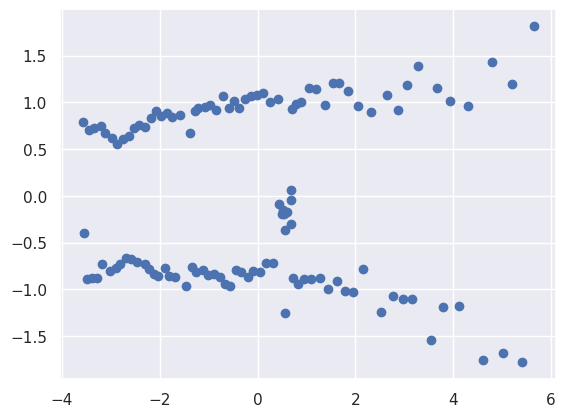

In [4]:
pca = PCA(n_components=4)
embs = pca.fit_transform(model.emb[0].detach().cpu().numpy())
print("PCA:", pca.explained_variance_ratio_, "\n")
plt.plot(embs[:, 0], embs[:, 1], "o")

Now, I'm going to do a simple analysis to see how the model predictions changes as I keep Z fixed and vary N.

In [5]:
task_names = list(data.output_map.keys())   # get a list of names of tasks (e.g. binding_semf)
magic_numbers = [2, 8, 20, 28, 50, 82, 126][1::]
# keep Z fixed and change N see how BE changes.
task_name = "binding_semf"
task_idx = task_names.index(task_name)
protons = 82
max_neutrons = 130
inputs = torch.full((max_neutrons - 9, 3), protons) # 9 is the minimum number of neutrons
inputs[:, 1] = torch.arange(9, max_neutrons) # change the number of neutrons
inputs[:, 2] = task_idx # change the task index
preds = model(inputs)
preds = preds[:, task_idx].cpu().detach() # get the predictions for the task

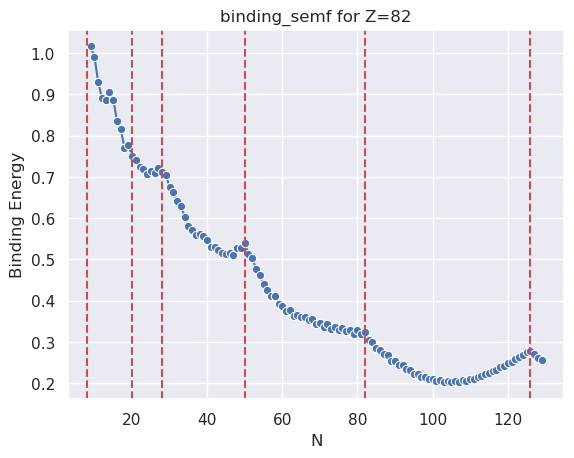

In [6]:
sns.lineplot(x=inputs[:, 1], y=preds, marker='o')
for magic_number in magic_numbers:
    plt.axvline(magic_number, color='r', linestyle='--')
plt.xlabel("N")
plt.ylabel("Binding Energy")
plt.title(f"{task_name} for Z={protons}")
plt.savefig(f"plots/Z_{protons}_{task_name}.pdf", bbox_inches='tight', pad_inches=0)

Now, let's take a look at how the model predictions compare to the data.

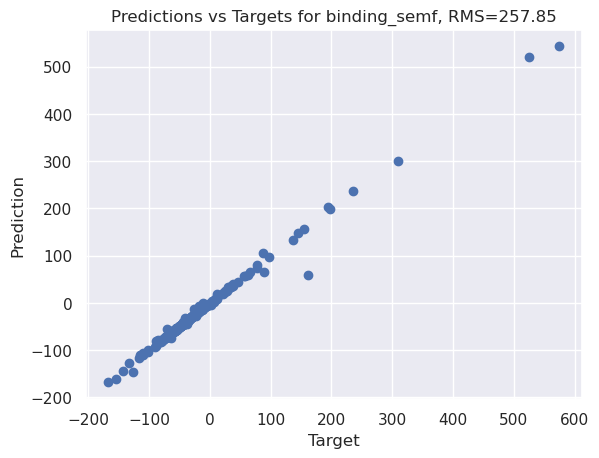

RMS: 257.85


In [7]:
def preds_targets_zn(model, task_name, train=True):
    # the data has an admittedly weird structure
    # data.X is a tensor of shape (N, 3) where N is the number of nuclei
    # TIMES the number of tasks. The first column is the number of protons,
    # the second column is the number of neutrons, and the third column is
    # the task index. 
    mask = data.train_mask if train else data.val_mask
    task_idx = task_names.index(task_name)
    X_train = data.X[mask]
    scatter = X_train[:, 2].cpu().numpy() == task_idx # get only rows relevant to task

    # get the targets and predictions for the task
    # first, we need to undo the preprocessing
    # data.regresion_transformer is a sklearn transformer that does the preprocessing
    # we can use its inverse_transform method to undo the preprocessing
    # it expects a numpy array, of shape (samples, features) where features is the number
    # of tasks we have.
    targets = data.y.view(-1, 10).cpu().numpy()
    targets = data.regression_transformer.inverse_transform(targets)
    targets = targets.flatten()[mask.cpu().numpy()]
    targets = targets[scatter]

    # Predictions on the other hand are shape (samples, tasks)
    # each row has one correct prediction, and the rest are not useful
    # this is not optimal but not worth optimizing for now
    preds = model(data.X[mask])
    preds = preds.cpu().detach().numpy()
    preds = data.regression_transformer.inverse_transform(preds)[scatter, task_idx]
    return preds, targets, X_train[scatter, :2].cpu().numpy()

def get_rms(preds, targets, zn, scale_by_A=False):
    non_nan_targets = ~np.isnan(targets)
    targets = targets[non_nan_targets]
    preds = preds[non_nan_targets]
    zn = zn[non_nan_targets]
    if scale_by_A:
        factor = zn.sum(1)
    else:
        factor = 1
    rms = np.sqrt(np.mean(((preds - targets)* factor)**2) )
    return rms

def plot_predictions(model, task_name, train=True):
    preds, targets, zn = preds_targets_zn(model, task_name, train)  
    rms = get_rms(preds, targets, zn, scale_by_A="binding_semf" == task_name)

    plt.plot(targets, preds, "o")
    plt.xlabel("Target")
    plt.ylabel("Prediction")
    plt.title(f"Predictions vs Targets for {task_name}, RMS={rms:.2f}")
    plt.show()
    print(f"RMS: {rms:.2f}")
    
plot_predictions(model, "binding_semf", train=False)

# II. Sparse Autoencoder on Embeddings
Now we will follow Anthropic's dictionary learning approach of training a sparse autoencoder to uncover a latent space that is more interpretable.

In [11]:
class AutoEncoder(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim):
    super().__init__()
    self.encoder = torch.nn.Linear(input_dim, hidden_dim, bias=True)
    self.decoder = torch.nn.Linear(hidden_dim, input_dim, bias=False)
    self.input_bias = torch.nn.Parameter(torch.zeros(input_dim))

  def forward(self, x):
    x = self.encoder(x - self.input_bias)
    acts = torch.nn.functional.relu(x)
    x = self.decoder(acts) + self.input_bias
    return x, acts

  def loss(self, x, lambda_l1=.1):
    y, acts = self(x)
    return torch.nn.functional.mse_loss(y, x) + lambda_l1 * acts.abs().mean()


In [12]:
from copy import deepcopy
from tqdm.notebook import trange

orig_state_dict = deepcopy(model.state_dict())

In [10]:
model.load_state_dict(orig_state_dict)
epochs = 5

aes = []
for i, emb in enumerate(model.emb):
    emb = emb.detach().cpu().clone()
    ae = AutoEncoder(emb.shape[1], 10*emb.shape[1])
    optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)
    for _ in (pbar:=trange(epochs)):
        loss = ae.loss(emb, lambda_l1=.01)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # try rms with ae embeddings
        model.emb[i].data = ae(emb)[0].data.to(device)
        preds, targets, zn = preds_targets_zn(model, "binding_semf", train=False)
        rms = get_rms(preds, targets, zn, scale_by_A=True)
        
        preds, targets, zn = preds_targets_zn(model, "binding_semf", train=True) 
        rms_ = get_rms(preds, targets, zn, scale_by_A=True)
        pbar.set_description(f"Loss: {loss.item():.2e}, val_rms: {rms:.2f}, train_rms: {rms_:.2f}")
    aes.append(ae)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

PCA: [9.8760098e-01 8.8629322e-03 8.3029020e-04 2.4494366e-04] 



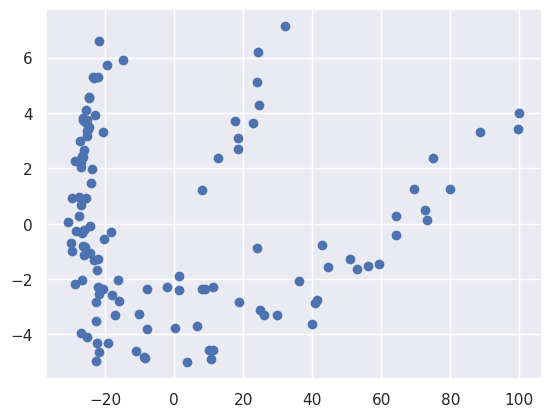

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)

big_emb = aes[0](model.emb[0].detach().cpu())[1].detach().numpy()
big_emb_pca = pca.fit_transform(big_emb)
print("PCA:", pca.explained_variance_ratio_, "\n")

plt.plot(big_emb_pca[:, 0], big_emb_pca[:, 1], "o")

In [14]:
model.load_state_dict(orig_state_dict)

<All keys matched successfully>

## Reverting Back to Binding Energies
Let's convert the model predictions to actual binding energies in keV. The model we trained predicts differences from the semi-empirical mass formula (SEMF) binding energies. So, we need to add the SEMF binding energies back to the model predictions to get the actual binding energies.

In [15]:
from data import get_nuclear_data, get_targets, semi_empirical_mass_formula
import pandas as pd


zn = data.X[::len(data.output_map), :2].cpu().numpy()
y_orig = data.regression_transformer.inverse_transform(data.y.view(-1, len(data.output_map)).cpu().numpy())

df_data = np.concatenate([zn, y_orig], axis=1)
df_data = pd.DataFrame(df_data, columns=["Z", "N"]+task_names)
df_data["binding"] = semi_empirical_mass_formula(df_data["Z"], df_data["N"]) + df_data["binding_semf"]
df_data.head()

,Z,N,binding_semf,z,n,radius,qa,qbm,qbm_n,qec,sn,sp,binding
0,9.0,9.0,-94.804138,9.0,9.000000,NaN,-4415.221191,-4444.505859,-23698.658203,1655.928345,9149.907227,5607.094727,7631.638295
1,9.0,10.0,-224.958405,9.0,10.000000,2.8976,-4013.798828,-3239.498291,-14876.380859,-4820.303711,10431.875977,7993.599609,7779.019195
2,9.0,11.0,-167.327927,9.0,11.000000,NaN,-8126.286133,7024.470703,-9840.835938,-3813.634766,6601.335938,10639.291992,7720.135103
3,9.0,12.0,-192.668701,9.0,12.000000,NaN,-10342.599609,5684.170410,-1076.991821,-8109.638672,8101.459961,11132.748047,7738.293393
4,9.0,13.0,-50.938557,9.0,13.000001,NaN,-12744.707031,10818.090820,453.832184,-6489.656738,5230.336914,12557.628906,7624.295398


We can use the `preds_targets_zn` function to convert a specifc key to its original units. The function returns converted predictions, targets and the corresponding N and Z values.

In [16]:
preds, targets, zn = preds_targets_zn(model, "binding_semf", train=True)
preds += semi_empirical_mass_formula(zn[:, 0], zn[:, 1])
targets += semi_empirical_mass_formula(zn[:, 0], zn[:, 1])

df_train = np.concatenate((zn, preds.reshape(-1, 1), targets.reshape(-1, 1)), axis=1)
df_train = pd.DataFrame(df_train, columns=["Z", "N", "pred", "target"])
df_train.head()

,Z,N,pred,target
0,9.0,9.0,7800.554688,7631.638184
1,9.0,10.0,8029.394043,7779.019043
2,9.0,11.0,7999.459473,7720.135254
3,9.0,12.0,7982.310547,7738.293457
4,9.0,13.0,7782.455078,7624.295410


## Nuclear Embeddings

Let's take a look at the *nuclear* embeddings *i.e.* the first layer output of the model after combining N, Z, and target embeddings.

In [17]:
def unscale(x, task_name):
    task_idx = task_names.index(task_name)
    min_ = data.regression_transformer.data_min_[task_idx]
    max_ = data.regression_transformer.data_max_[task_idx]
    x = x * (max_ - min_) + min_
    return x

In [18]:
for n, p in model.named_parameters():
    print(n, p.shape)

emb.0 torch.Size([119, 2048])
emb.1 torch.Size([179, 2048])
emb.2 torch.Size([10, 2048])
nonlinear.0.weight torch.Size([2048, 6144])
nonlinear.0.bias torch.Size([2048])
nonlinear.2.ff.0.weight torch.Size([2048, 2048])
nonlinear.2.ff.0.bias torch.Size([2048])
nonlinear.2.ff.2.weight torch.Size([2048, 2048])
nonlinear.2.ff.2.bias torch.Size([2048])
nonlinear.3.ff.0.weight torch.Size([2048, 2048])
nonlinear.3.ff.0.bias torch.Size([2048])
nonlinear.3.ff.2.weight torch.Size([2048, 2048])
nonlinear.3.ff.2.bias torch.Size([2048])
readout.weight torch.Size([10, 2048])
readout.bias torch.Size([10])


In [19]:
# Let's cut up the model and test that it still works
znt = data.X[data.X[:, 2] == task_names.index("binding_semf")].cpu()
targets = data.y[data.X[:, 2] == task_names.index("binding_semf")].cpu().detach()
embs = model.embed_input(znt, model.emb)
embs = model.nonlinear[0](embs)
# ^ this will be our first half, from input to first layer after
# combining the Z, N and T embeddings

# Now we need to get the second half, which is the second
# layer after combining the embeddings all the way to the readout
readout = lambda x: model.readout(model.nonlinear[1:](x))
preds = readout(embs)[:, 0].cpu().detach()
preds = unscale(preds.numpy().flatten(), "binding_semf")
targets = unscale(targets.numpy().flatten(), "binding_semf")
rms_cut_up = get_rms(preds, targets, znt.numpy()[:, :2], scale_by_A=True)

# Now let's test the original model
preds = model(znt)[:, 0].cpu().detach().numpy()
preds = unscale(preds.flatten(), "binding_semf")
rms_original = get_rms(preds, targets, znt.numpy()[:, :2], scale_by_A=True)
print(f"RMS for original model: {rms_original:.2f}")
print(f"RMS for cut up model: {rms_cut_up:.2f}")

RMS for original model: 18721.86
RMS for cut up model: 18721.86


PCA: [9.3946576e-01 4.2833254e-02 9.6887285e-03 1.8947835e-03 1.3460247e-03
 6.7547197e-04 4.0354743e-04 3.8314023e-04 2.4095025e-04 2.2763164e-04] 



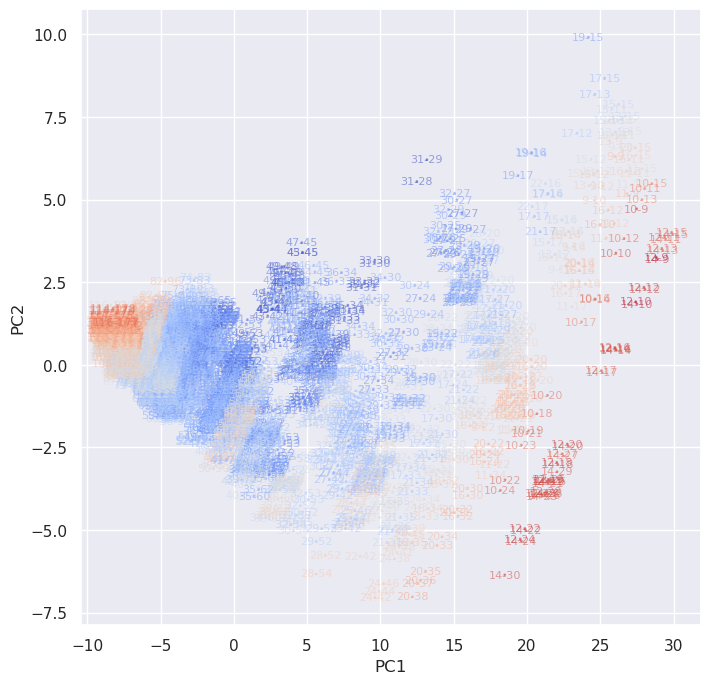

In [20]:
pca = PCA(n_components=10)
embs_pca = pca.fit_transform(embs.detach().cpu().numpy())
print("PCA:", pca.explained_variance_ratio_, "\n")

def scatter_2d_nuclei(x_axis_pc, y_axis_pc, color_pc):
    x = embs_pca[:, x_axis_pc]
    y = embs_pca[:, y_axis_pc]
    colors = embs_pca[:, color_pc]
    colors = (colors-min(colors))/(max(colors)-min(colors))
    colors = plt.cm.coolwarm(colors)

    fig, ax = plt.subplots(figsize=(8, 8))
    for idx, coords in enumerate(zip(x, y)):
        zn = znt[idx, :2].cpu().numpy()
        plt.text(coords[0], coords[1], f"{zn[0]}-{zn[1]}", fontsize=8, ha="center", va="center", color=colors[idx], alpha=0.5)
    plt.scatter(x, y, c=colors, alpha=0.5, s=1)

    plt.xlabel(f"PC{x_axis_pc+1}")
    plt.ylabel(f"PC{y_axis_pc+1}")
    # plt.axis("off")
    plt.show()
    
for i in range(1):
    for j in range(i+1, 2):
        scatter_2d_nuclei(i, j, j+1)

In [21]:
# save the data to disk
df = pd.DataFrame(data=embs_pca, columns=[f"PC{i+1}" for i in range(10)])
df["zn"] = [f"{z}-{n}" for z, n, t in zip(*znt.T)]
df["z"] = znt[:, 0].cpu().numpy()
df["n"] = znt[:, 1].cpu().numpy()
df.to_csv("data/nuclear_pca.csv", index=False)

Let's take a look at different views of the nuclear embeddings PCs against each other and Z and N values.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


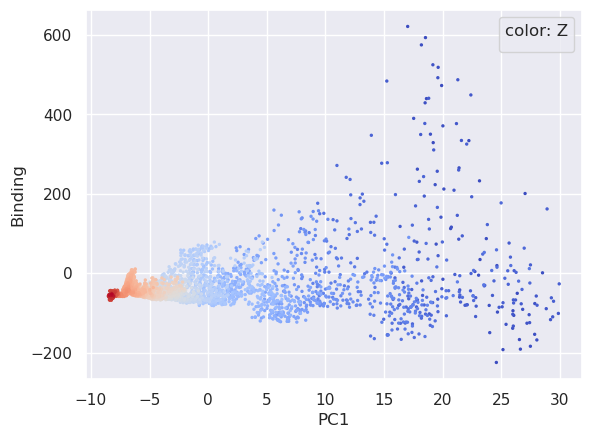

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


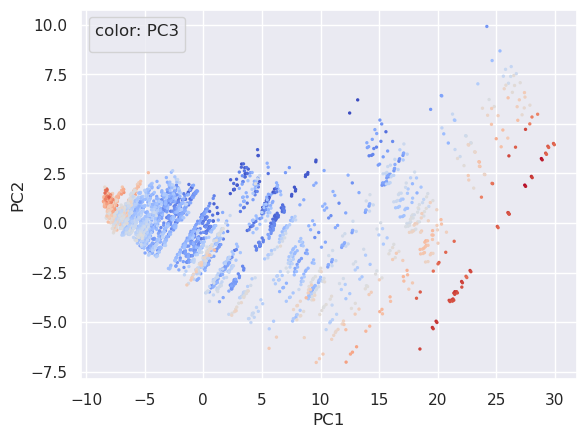

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


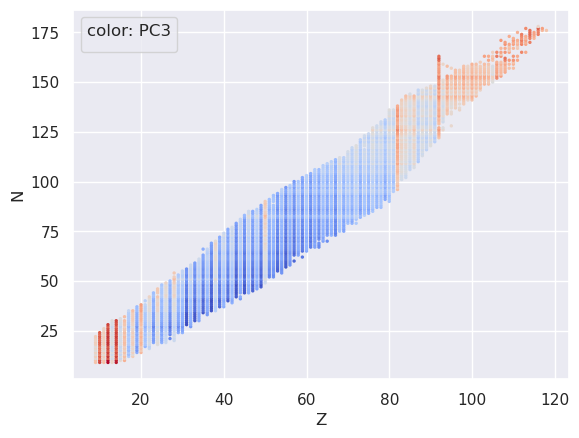

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


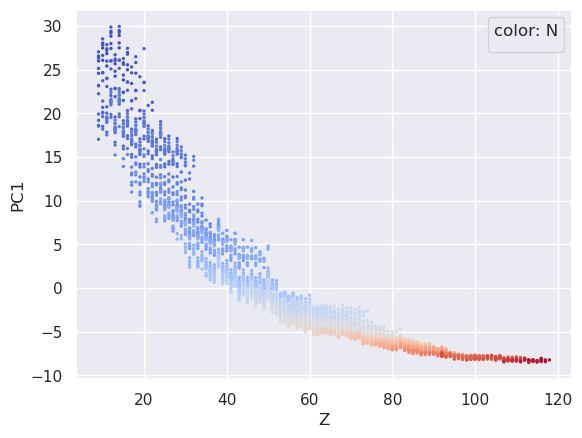

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


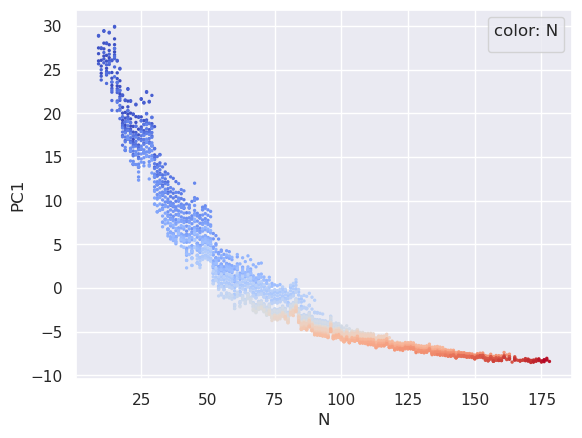

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


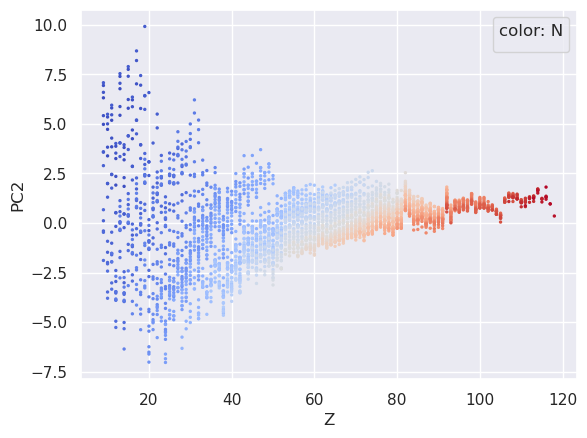

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


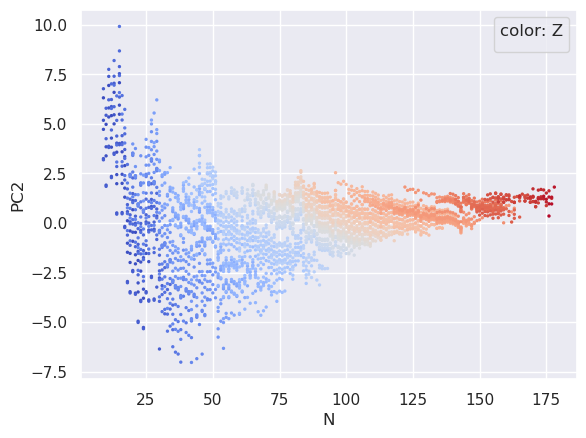

In [22]:
x_axis_pc = 0
y_axis_pc = 1
zn = znt[:, :2].cpu().numpy()
plt.scatter(embs_pca[:, x_axis_pc],targets, c=zn[:, 0], cmap="coolwarm", s=2)
plt.ylabel("Binding")
plt.xlabel(f"PC{x_axis_pc+1}")
plt.legend(title=f"color: Z")
plt.show()


plt.scatter(embs_pca[:, x_axis_pc], embs_pca[:, y_axis_pc], c=embs_pca[:, y_axis_pc+1], cmap="coolwarm", s=2)
plt.xlabel(f"PC{x_axis_pc+1}")
plt.ylabel(f"PC{y_axis_pc+1}")
plt.legend(title=f"color: PC{y_axis_pc+2}")
plt.show()
plt.scatter(zn[:, 0], zn[:, 1], c=embs_pca[:, y_axis_pc+1], cmap="coolwarm", s=2)
plt.xlabel("Z")
plt.ylabel("N")
plt.legend(title=f"color: PC{y_axis_pc+2}")
plt.show()
plt.scatter(zn[:, 0], embs_pca[:, x_axis_pc], c=zn[:, 1], cmap="coolwarm", s=2) 
plt.xlabel("Z")
plt.ylabel(f"PC{x_axis_pc+1}")
plt.legend(title=f"color: N")
plt.show()
plt.scatter(zn[:, 1], embs_pca[:, x_axis_pc], c=zn[:, 0], cmap="coolwarm", s=2)
plt.xlabel("N")
plt.ylabel(f"PC{x_axis_pc+1}")
plt.legend(title=f"color: N")
plt.show()
plt.scatter(zn[:, 0], embs_pca[:, y_axis_pc], c=zn[:, 1], cmap="coolwarm", s=2)
plt.xlabel("Z")
plt.ylabel(f"PC{y_axis_pc+1}")
plt.legend(title=f"color: N")
plt.show()
plt.scatter(zn[:, 1], embs_pca[:, y_axis_pc], c=zn[:, 0], cmap="coolwarm", s=2)
plt.xlabel("N")
plt.ylabel(f"PC{y_axis_pc+1}")
plt.legend(title=f"color: Z")
plt.show()



map from PCs to binding energies

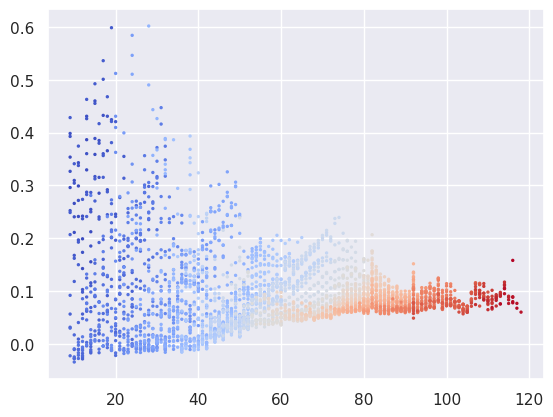

In [23]:
energies = model(znt)[:, task_names.index("binding_semf")].cpu().detach().numpy()
# energies += semi_empirical_mass_formula(znt[:, 0], znt[:, 1]).cpu().detach().numpy()
plt.scatter(zn[:, 0], energies, c=zn[:, 1], cmap="coolwarm", s=2)

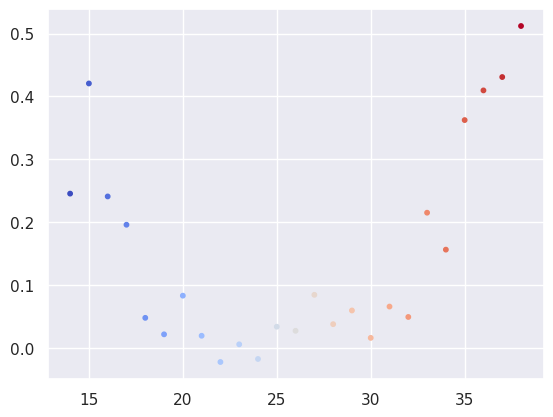

In [24]:
x_axis_pc = 0
mask = zn[:, 0] == 20
c = zn[mask, 1]
x_axis = zn[mask, 1]
y_axis = energies[mask]
plt.scatter(x_axis, y_axis, c=c, cmap="coolwarm", s=10)

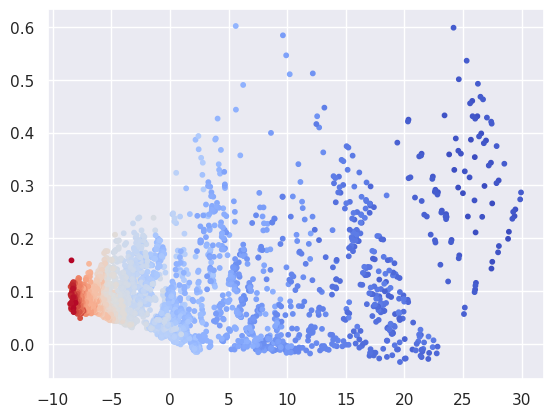

In [25]:
x_axis_pc = 0
mask = zn[:, 0] != 0
c = zn[mask, 1]
x_axis = embs_pca[mask, x_axis_pc]
y_axis = energies[mask]
plt.scatter(x_axis, y_axis, c=c, cmap="coolwarm", s=10)

Time to train a sparse autoencoder on the nuclear embeddings.

In [26]:
model.load_state_dict(orig_state_dict)
model.to(device)
epochs = 5
emb = embs.detach().clone().to(device)
zn = znt.numpy()[:, :2]
ae_nuclear = AutoEncoder(emb.shape[1], 10 * emb.shape[1]).to(device)
optimizer = torch.optim.Adam(ae_nuclear.parameters(), lr=1e-3)
for _ in (pbar:=trange(epochs)):
    loss = ae_nuclear.loss(emb, lambda_l1=0.01)
    emb_reco = ae_nuclear(emb)[0]
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # try rms with ae embeddings
    preds = readout(emb_reco)[:, 0].data.cpu().numpy().flatten()
    preds = unscale(preds.flatten(), "binding_semf")
    rms = get_rms(preds, targets, zn, scale_by_A=True)
    pbar.set_description(f"Loss: {loss.item():.2e}, rms: {rms:.2f}")

  0%|          | 0/5 [00:00<?, ?it/s]

# III. Studying the importance of the different principal components

In [27]:
from functools import lru_cache as cache
from torch import nn


class EmbeddingModel:
    def __init__(self, model, n_components=-1) -> None:
        self.model = model
        self.device = model.emb[0].device
        # save original embs
        self.orig_embs = [None] * len(model.emb)
        for i, emb in enumerate(model.emb):
            self.orig_embs[i] = emb.detach().clone()

        # fit and transform embs
        self.pca = [None] * len(model.emb)
        self.orig_embs_pca = [None] * len(model.emb)
        for i, emb in enumerate(model.emb):
            n = min(n_components, *emb.shape)
            self.pca[i] = PCA(n_components=n)
            self.orig_embs_pca[i] = self.pca[i].fit_transform(emb.detach().cpu().numpy())


    def interpolate(self, ith_pc, which, starting_emb):
        result = {}
        for i, start in zip(which, starting_emb):
            emb = self.orig_embs_pca[i]
            central_value = emb[start, ith_pc]
            min_val = min(emb[:, ith_pc])
            max_val = max(emb[:, ith_pc])
            values = np.linspace(min_val, max_val, len(emb))
            result[i] = (central_value, values)
        return result

    def _replace_embs(self, new_embs: [dict, list]):
        if isinstance(new_embs, list):
           for i, emb in enumerate(new_embs):
               self.model.emb[i].data = emb.to(self.device).float()
        else:
            for i, emb in new_embs.items():
                self.model.emb[i].data = emb.to(self.device).float()

    @cache
    def _keep_npcs(self, n_pcs=-1, which=None, inverse=True):
        embs = {}
        if which is None:
            which = self.pca.keys()
        for i in which:
            embs[i] = self.orig_embs_pca[i].copy()
            embs[i][:, n_pcs:] = 0
            if inverse:
                embs[i] = torch.from_numpy(self.pca[i].inverse_transform(embs[i]))
            else:
                embs[i] = torch.from_numpy(embs[i][:, :n_pcs])
        return embs

    def reset_embs(self):
        self._replace_embs(self.orig_embs)

    def keep_npcs(self, n_pcs=-1, which=None):
        embs = self._keep_npcs(n_pcs, which)
        self._replace_embs(embs)

100%|██████████| 500/500 [00:06<00:00, 83.03it/s]


Text(0, 0.5, 'Binding Energy Error')

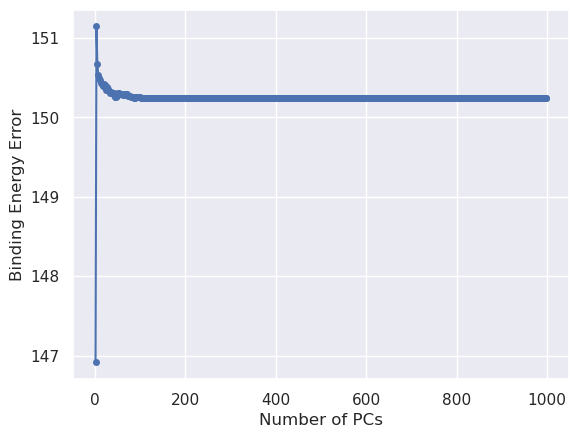

In [28]:
import tqdm

max_pc = 1000
pca_model = EmbeddingModel(model, n_components=max_pc)
results = []
pc_range = range(1, max_pc, 2)
for i in tqdm.tqdm(pc_range):
    pca_model.keep_npcs(n_pcs=i, which=(0, ))
    preds, targets, zn = preds_targets_zn(model, "binding_semf", train=False)
    rms = get_rms(preds, targets, zn, scale_by_A=False)
    results.append(rms)
    pca_model.reset_embs()
    
plt.plot(pc_range, results, marker='o', markersize=4, label="Proton")
plt.xlabel("Number of PCs")
plt.ylabel("Binding Energy Error")

# IV. Fine-tuning using low-dimensional features

Now let's fine-tune the model starting with the first few PCs

In [29]:
class replace_linear_wbias(nn.Module):
    """Module that removes a linear layer and only keeps its bias."""
    def __init__(self, linear) -> None:
        super().__init__()
        self.bias = nn.Parameter(linear.bias)

    def forward(self, x):
        # here x is a concatenation of N, Z, and T embeddings
        # linear is a weighted sum and because we are absorbing the weights
        # all we have to do is add in the bias
        xs = x.chunk(3, dim=1)
        x = sum(xs)
        return x + self.bias
    
class AbsorbWeight(nn.Module):
    """Module that absorbs a PCA inverse transformation into weights and biases of a linear layer"""
    def __init__(self, linear, pre_weights, pre_biases) -> None:
        super().__init__()
        weights = [p@w.T for p, w in zip(pre_weights, linear.weight.chunk(3, dim=1))]
        self.weight = nn.Parameter(torch.cat(weights, dim=0))
        
        biases = [b@w.T for b, w in zip(pre_biases, linear.weight.chunk(3, dim=1))]
        self.bias = nn.Parameter(linear.bias.data.clone() + sum(biases))
        
    def forward(self, x):
        return x @ self.weight + self.bias
    
def quick_eval(model, verbose=True):
    """helper to get the rms for the franken model"""
    preds, targets, zn = preds_targets_zn(model, "binding_semf", train=False)
    rms = get_rms(preds, targets, zn, scale_by_A=True)
    if verbose:
        print(f"RMS for franken model: {rms:.2f}")
    return rms


In [30]:
franken_model, _ = get_model_and_optim(data, args)
franken_model.load_state_dict(model_final)

quick_eval(franken_model)

# let's consolidate the first layer into the embeddings the rms should not change
# when we use a large number of max pcs
max_pcs = [5, 5, 10]
weights = franken_model.nonlinear[0].weight.data.chunk(3, dim=1)
O_matrices, means = [], []
for weight, emb, max_pc in zip(weights, franken_model.emb, max_pcs):
    # weight is H x 3d and emb is N x d, EMB @ WEIGHT.T is the normal operation
    dim = min(emb.shape)
    pca = PCA(n_components=dim).fit(emb.detach().cpu().numpy())
    O = torch.from_numpy(pca.components_).to(emb.data.device)[:max_pc]
    mean_ = emb.data.mean(0)
    # Insert a low rank approximation of the weights into the embeddings
    # emb.data = ((emb.data - mean_) @ O.T @ O + mean_) @ weight.T
    emb.data = (emb.data - mean_) @ O.T
    O_matrices.append(O), means.append(mean_)

franken_model.nonlinear[0] = AbsorbWeight(franken_model.nonlinear[0], O_matrices, means)

# franken_model.nonlinear[0] = replace_linear_wbias(franken_model.nonlinear[0])
rms = quick_eval(franken_model)

RMS for franken model: 257.85
RMS for franken model: 1951.82


In [31]:
# setup training data
X_train = data.X[data.train_mask]
y_train = data.y[data.train_mask]
non_nan_targets = ~torch.isnan(y_train.view(-1))
X_train = X_train[non_nan_targets]
y_train = y_train[non_nan_targets]

# disable grads on everything but the embeddings
for name, param in franken_model.named_parameters():
    if "emb" not in name:
        param.requires_grad = False

In [32]:
franken_model = franken_model.to("cuda")
optimizer = torch.optim.Adam(franken_model.parameters(), lr=1e-5)
epochs = 10000

x = X_train[X_train[:, 2] == task_names.index("binding_semf")]
y = y_train[X_train[:, 2] == task_names.index("binding_semf")]

for _ in (pbar:=trange(epochs)):
    preds = franken_model(x)
    preds = preds[torch.arange(len(preds)), x[:, 2]].view(-1)
    targets = y.view(-1)
    loss = torch.nn.functional.mse_loss(preds, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    rms = quick_eval(franken_model, verbose=False)
    pbar.set_description(f"Loss: {loss.item():.2e}, rms: {rms:.2f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

In [33]:
preds = franken_model(x)
preds = preds[torch.arange(len(preds)), x[:, 2]].view(-1)
targets = y.view(-1)
loss = torch.nn.functional.mse_loss(preds, targets)
loss.backward()
# print grads
for n, p in franken_model.named_parameters():
    if p.grad is not None:
        print(n, p.grad.norm().item())

emb.0 2.3881069864728488e-05
emb.1 3.5059281799476594e-05
emb.2 1.7268426745431498e-05


In [34]:
def scatter_text(strings, x, y, colors=None, ax=None, fontsize=12, **kwargs):
    if 'ha' not in kwargs.keys():
        kwargs['ha'] = 'left'
    if 'va' not in kwargs.keys():
        kwargs['va'] = 'bottom'

    strings = [str(s) for s in strings]
    colors = colors if colors is not None else ['k'] * len(x)
    if not isinstance(colors[0], str):
        colors = (colors-min(colors))/(max(colors)-min(colors))
        colors = plt.cm.coolwarm(colors)
    if not ax:
        ax = plt.gca()
    for s, x, y, c in zip(strings, x, y, colors):
        ax.text(x, y, s, fontsize=fontsize, c=c, **kwargs)
    return ax

In [40]:
franken_model.emb

ParameterList(
    (0): Parameter containing: [torch.float32 of size 119x5 (GPU 0)]
    (1): Parameter containing: [torch.float32 of size 179x5 (GPU 0)]
    (2): Parameter containing: [torch.float32 of size 10x10 (GPU 0)]
)

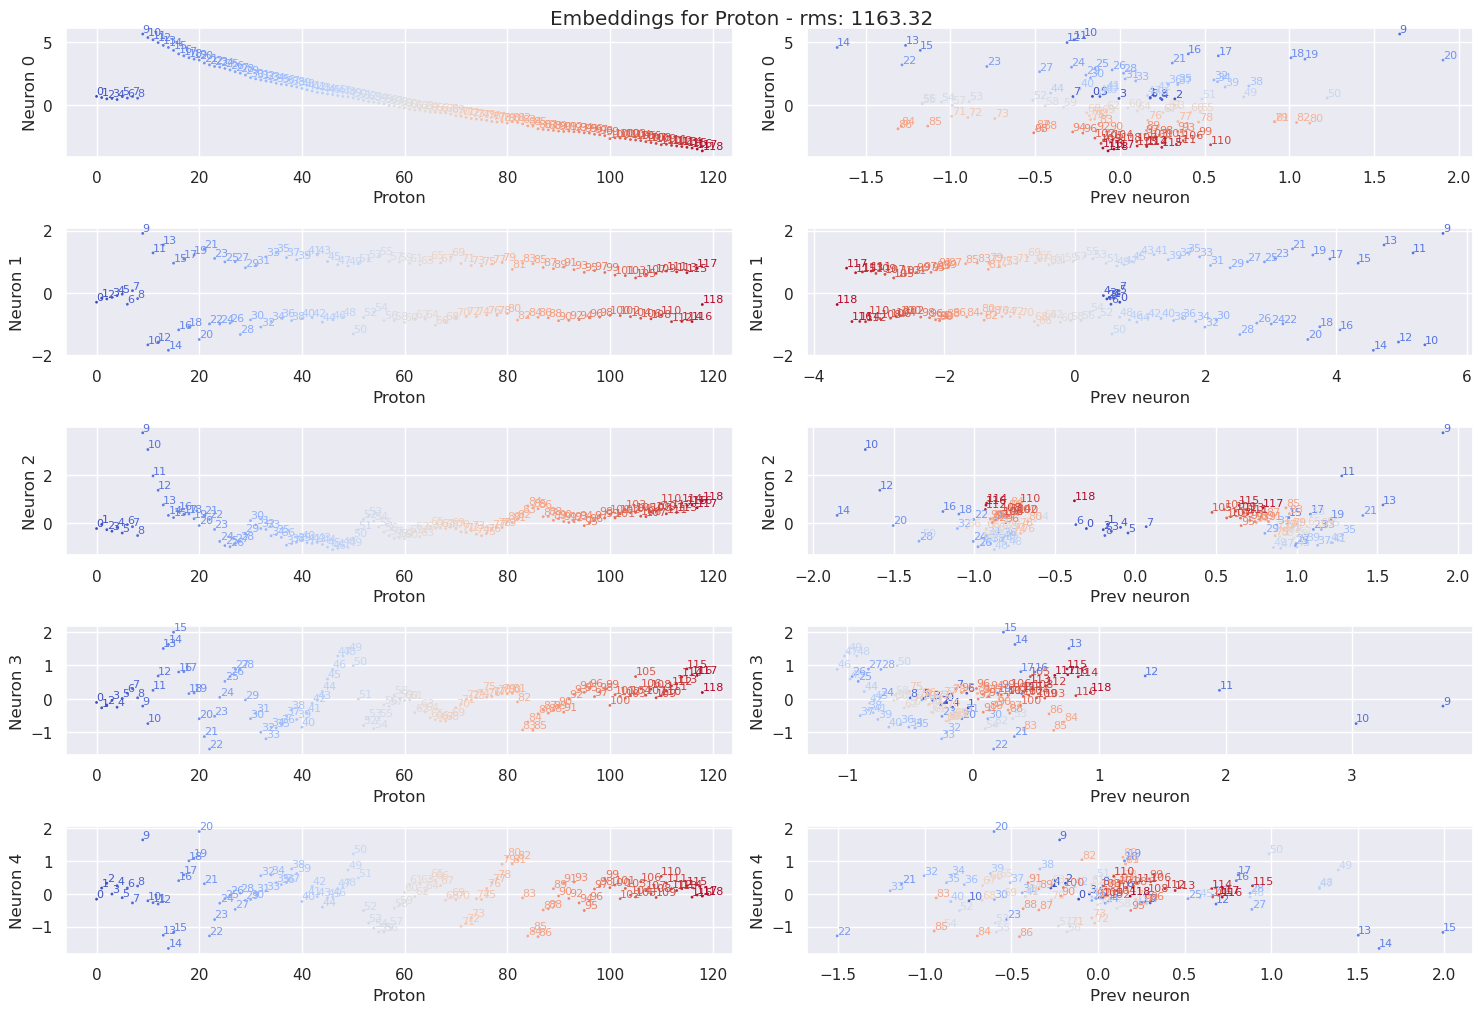

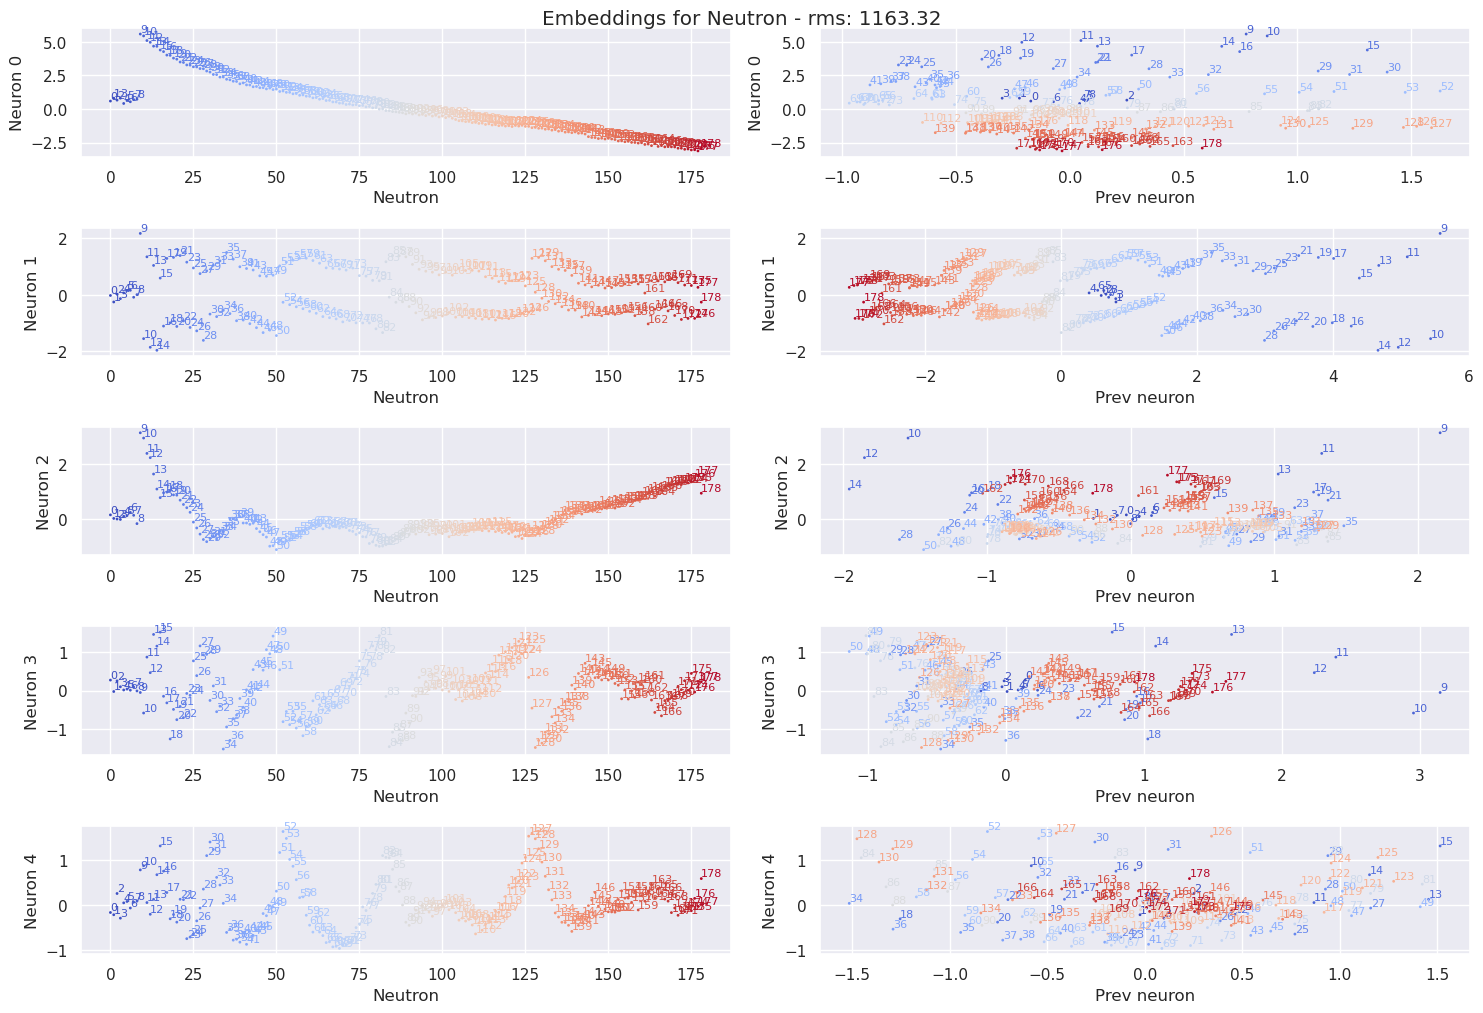

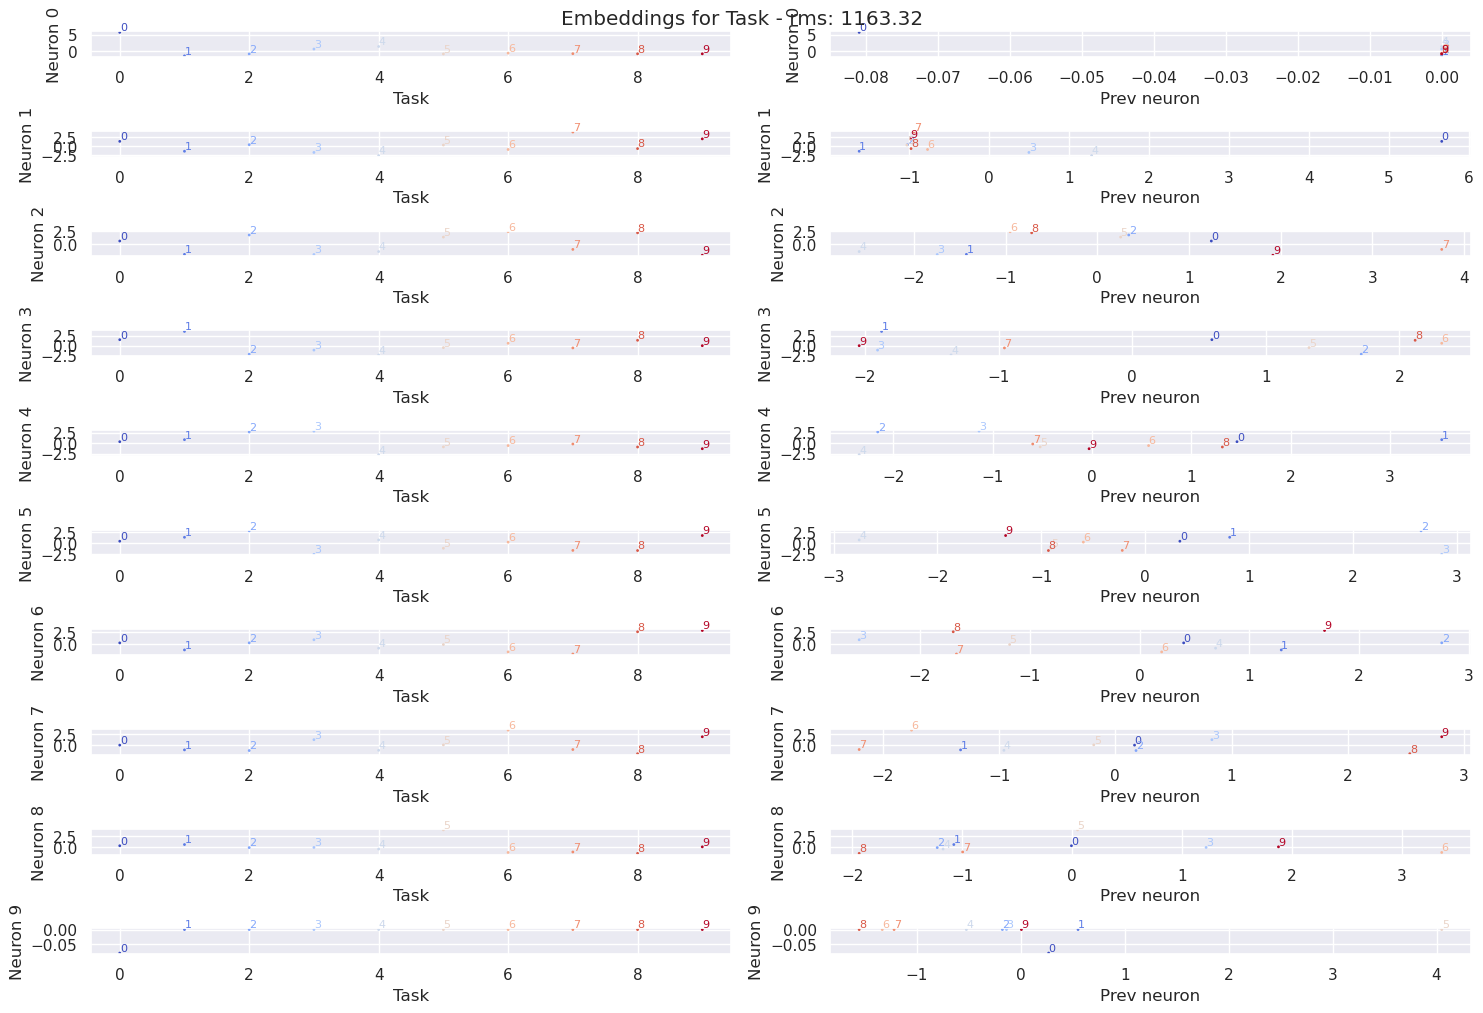

In [38]:
# let's take a look at our embeddings
titles = ["Proton", "Neutron", "Task"]
for i, emb in enumerate(franken_model.emb):
    emb = emb.detach().cpu().numpy()
    fig = plt.figure(figsize=(15, 20))
    for neuron in range(emb.shape[1]):
        x_axis = np.arange(emb.shape[0])
        plt.subplot(emb.shape[1]*2, 2, 2 *neuron+1)
        plt.scatter(x_axis, emb[:, neuron], c=x_axis, cmap="coolwarm", s=1)
        scatter_text(x_axis, x_axis, emb[:, neuron], x_axis, fontsize=8)
        plt.xlabel(titles[i]), plt.ylabel(f"Neuron {neuron}")
        

        plt.subplot(emb.shape[1]*2, 2, 2*neuron+2)
        plt.scatter(emb[:, neuron-1], emb[:, neuron], c=x_axis, cmap="coolwarm", s=1)
        scatter_text(x_axis, emb[:, neuron-1], emb[:, neuron], x_axis, fontsize=8)
        plt.xlabel(f"Prev neuron"), plt.ylabel(f"Neuron {neuron}")

    fig.suptitle(f"Embeddings for {titles[i]} - rms: {rms:.2f}")
    fig.tight_layout() 
    plt.savefig(f"plots/LoRA/embeddings_{titles[i]}-rms{rms:.2f}.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()
        
        

## IV.1. Fine-tuning with LoRA on last layer Sparse Autoencoder
We will re-do the analysis above but this time we will fine-tune the model using LoRA on the last layer.

In [36]:
franken_model2, _ = get_model_and_optim(data, args)
franken_model2.load_state_dict(model_final)

# quick_eval(franken_model2)
acts = torch.zeros(len(X_train), 2048, device=device)
franken_model2.readout.register_forward_pre_hook(lambda m, i: acts.copy_(i[0].detach()))
franken_model2(X_train)
print(acts)

tensor([[ 0.1052,  0.8590,  0.1346,  ...,  0.4698,  0.2642,  0.3279],
        [-0.0095,  0.3816,  0.2476,  ...,  0.1278,  0.2417,  0.1143],
        [ 0.0988,  0.6745,  0.1639,  ...,  0.2192,  0.2277,  0.1641],
        ...,
        [ 0.4600, -0.1267,  0.4317,  ..., -0.1433,  0.3879, -0.1432],
        [ 0.4744, -0.1437,  0.3572,  ..., -0.1311,  0.3395, -0.1359],
        [ 0.4771, -0.1139,  0.3649,  ..., -0.1126,  0.3696, -0.1553]],
       device='cuda:0')


In [ ]:
ae = AutoEncoder(2048, 2048*16).to(device)

In [132]:
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)
epochs = 200
for _ in (pbar := trange(epochs)):
    acts_reco, hidden_features = ae(acts)
    reco = torch.nn.functional.mse_loss(acts_reco, acts)
    loss = reco + (reg := hidden_features.abs().mean()) * 0.01
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    sparsity = (hidden_features.abs() > 1e-4).float().sum(dim=1).mean()
    pbar.set_description(f"Loss: {reco.item():.2e}, reg: {reg.item():.2e}, sparsity: {sparsity.item():.2e}")

  0%|          | 0/200 [00:00<?, ?it/s]

In [138]:
U, S, V = torch.svd(hidden_features.data)
print(S[:40])